In [53]:
## import packages
import string
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import NMF
from sklearn.decomposition import PCA
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from scipy.spatial import distance
from adjustText import adjust_text
from collections import defaultdict
from textblob import TextBlob
import gensim
import re
import json
import pandas as pd
import numpy as np
import spacy
import itertools as it
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore") # ignore warnings
%matplotlib inline

**data cleaning**

In [54]:
## load the data
with open('speeches_by_president.json') as json_data:
    speeches = json.load(json_data)
    json_data.close()

In [55]:
## clean the data and store them in the texts
names = list(speeches.keys())
d_word2vec = defaultdict(list)
text = []

In [56]:
## haNumbers removes all strings that include a number
def hasNumbers(inputString):
    return bool(re.search(r'\d', inputString))

## define the data cleaning function for nlp
def nlp_cleaning(trans):
    tokens = word_tokenize(trans)
    # convert to lower case
    tokens = [w.lower() for w in tokens]    
    
    # remove punctuation from each word
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]

    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    
    #return words
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    words = [word for word in words if not hasNumbers(word)]
    
    # stemming of words
    porter = PorterStemmer()
    return [porter.stem(word) for word in words]

In [ ]:
## add each presidential speech in the order of names
for name in names:
    transcripts = speeches[name]['transcript']
    trans = u' '.join([" ".join([t for t in transcript]) for transcript in transcripts])
    trans = ' '.join(nlp_cleaning(trans))
    text.append(trans)

**Apply PCA after vectorizing speeches based on the word frequency**

In [ ]:
## find the cosine similarity of each trasncript
count_vectorizer = CountVectorizer(analyzer='word',
                                  ngram_range=(1, 1), stop_words='english',
                                  token_pattern='\\b[a-z][a-z]+\\b')
count_vectorizer.fit(text)
ng_vecs = count_vectorizer.transform(text)
speech_matrix = ng_vecs.toarray()
cos_matrix = cosine_similarity(ng_vecs, ng_vecs) # this matrix shows similarity among presidents

In [ ]:
## Apply PCA to the speech matrix generated by Countervectorizer
model = PCA(n_components=2)
model.fit(speech_matrix)
P = model.fit_transform(speech_matrix)

In [ ]:
## Normalize the 2-dimensional PCA result to find clusters
for i in range(len(P)):
    P[i] /= 2*distance.euclidean([0, 0], P[i])

**Plot PCA results of all presidents**

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15));
ax.set_xlim(-0.75, 0.75);
ax.set_ylim(-0.75, 0.75);
ax.scatter(P[:,0], P[:,1], color='b', s=60);
ax.set_title('normalized PCA / all presidents', fontsize=15);

texts = [plt.text(P[i, 0], P[i, 1], '%s' %names[i], fontsize=12, va='center', ha='center') for i in range(len(P))]
adjust_text(texts, arrowprops=dict(arrowstyle="->", color='black', lw=1));

In [ ]:
## K-means with 8 clusters
kmeans = KMeans(n_clusters=8, random_state=0)
kmeansoutput=kmeans.fit(P)

fig, ax = plt.subplots(figsize=(15, 15));
ax.set_xlim(-0.75, 0.75);
ax.set_ylim(-0.75, 0.75);
ax.scatter(P[:,0], P[:,1], c=kmeansoutput.labels_, s=90);
ax.set_title('normalized PCA / KMeans with 8', fontsize=15);

texts = [plt.text(P[i, 0], P[i, 1], '%s' %names[i], fontsize=14, va='center', ha='center') for i in range(len(P))];
adjust_text(texts, arrowprops=dict(arrowstyle="->", color='black', lw=1));

**Plot by party and term period**

In [35]:
## categorize by party
with open('president_info.json') as json_data:
    president_info = json.load(json_data)
    json_data.close()

In [36]:
## divide presidential terms into 4 categories
def termToPeriod(term):
    if term <= 12:
        return 0
    elif term <= 25:
        return 1
    elif term <= 33:
        return 2
    return 3

In [48]:
## convert data into pandas frames
df = pd.DataFrame(P, columns=['x', 'y'])
df['name'] = names
df['party'] = [president_info[names[i]][1] for i in range(len(names))]
df['term'] = [int(sum(president_info[names[i]][0])/len(president_info[names[i]][0])) for i in range(len(names))]
df['period']=df['term'].apply(lambda s: termToPeriod(s))
df2 = df[(df['party'] == 'Democrat') | (df['party'] == 'Republican')]

In [49]:
## define a color to the corresponsding party
def partyToColor(party):
    return list(df['party'].unique()).index(party)
df2['party'] = df2['party'].apply(lambda s: partyToColor(s))
party = df2['party']
period=df['period']

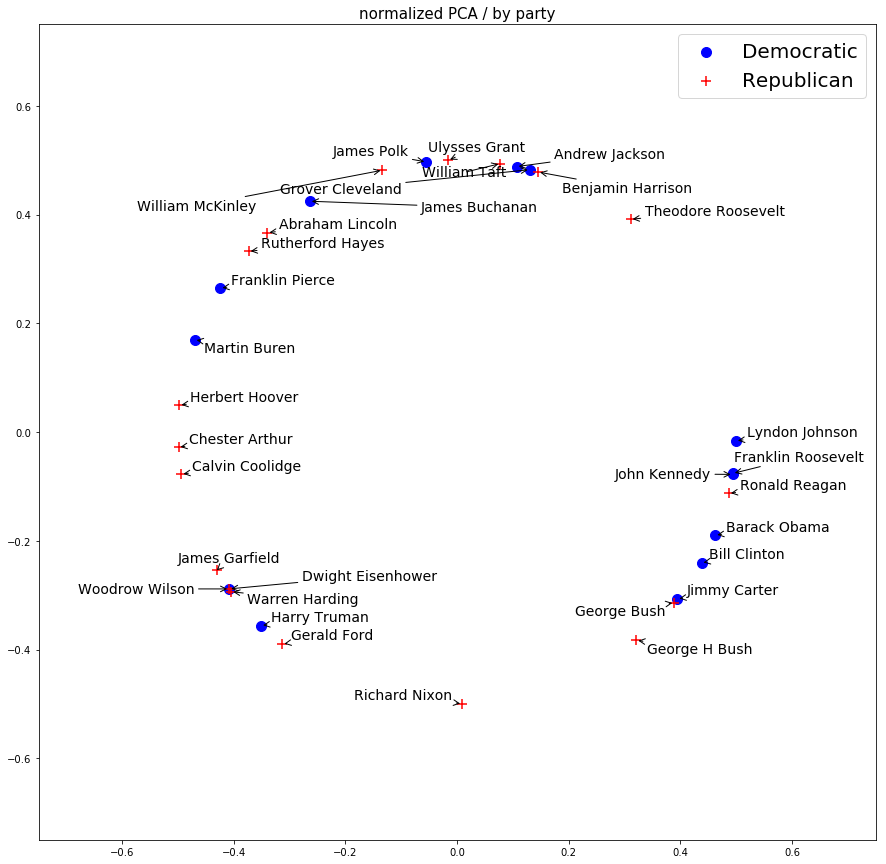

In [50]:
## plot the results by party
fig, ax = plt.subplots(figsize=(15, 15));
ax.set_xlim(-0.75, 0.75);
ax.set_ylim(-0.75, 0.75);
ax.scatter(df2[party==1].x, df2[party==1].y, marker='o', s=100, color='blue')
ax.scatter(df2[party==3].x, df2[party==3].y, marker='+', s=100, color='red')
ax.set_title('normalized PCA / by party', fontsize=15);

texts = [plt.text(df2.x.iloc[i], df2.y.iloc[i], '%s' %(df2['name'].iloc[i]), fontsize=14, va='center', ha='center') for i in range(len(df2))]
adjust_text(texts, arrowprops=dict(arrowstyle="->", color='black', lw=1))
ax.legend(loc='best', prop={'size': 20}, labels=['Democratic', 'Republican']);

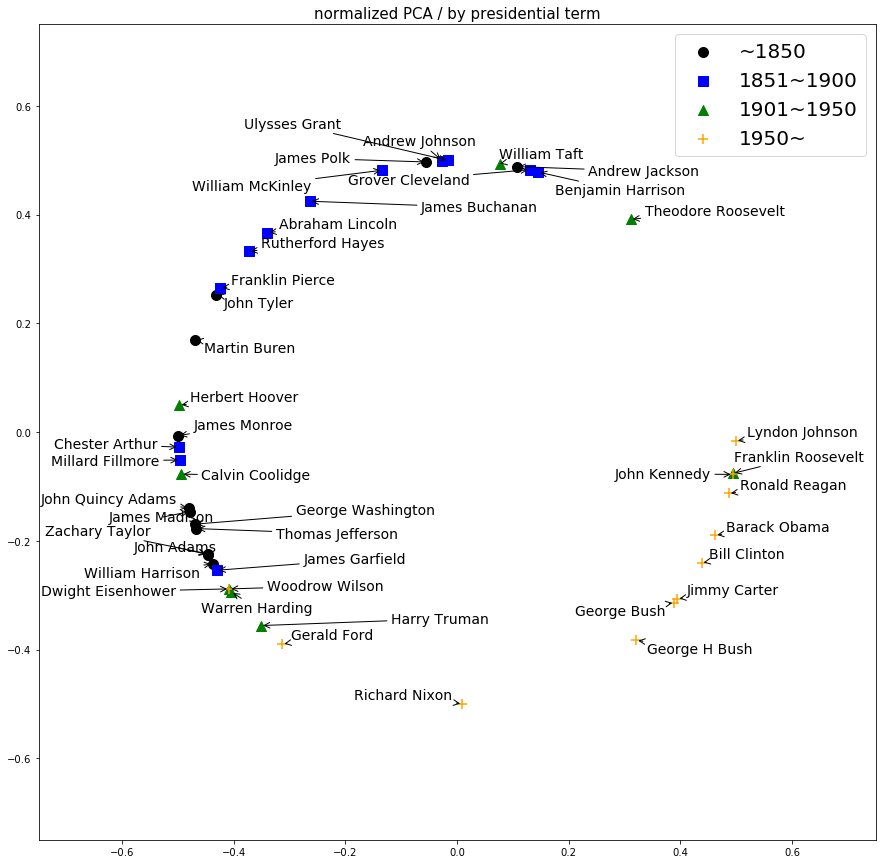

In [52]:
## plot the results by presidential term
fig, ax = plt.subplots(figsize=(15, 15));
ax.set_xlim(-0.75, 0.75);
ax.set_ylim(-0.75, 0.75);
ax.scatter(df[period==0].x, df[period==0].y, marker='o', s=100, color='black')
ax.scatter(df[period==1].x, df[period==1].y, marker='s', s=100, color='blue')
ax.scatter(df[period==2].x, df[period==2].y, marker='^', s=100, color='green')
ax.scatter(df[period==3].x, df[period==3].y, marker='+', s=100, color='orange')
ax.set_title('normalized PCA / by presidential term', fontsize=15);

texts = [plt.text(df.x.iloc[i], df.y.iloc[i], '%s' %(df['name'].iloc[i]), fontsize=14, va='center', ha='center') for i in range(len(df))]
adjust_text(texts, arrowprops=dict(arrowstyle="->", color='black', lw=1));
ax.legend(loc='best', prop={'size': 20}, labels = ['~1850', '1851~1900', '1901~1950', '1950~']);